<a href="https://colab.research.google.com/github/Smoulvad01/AI-C1-image-/blob/main/Image_Analysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <font color='green'>Import</font>

In [2]:
import cv2
from PIL import Image # To display images
from sklearn.decomposition import NMF, PCA

# TensorFlow and tf.keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Helper libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from sklearn.pipeline import Pipeline
import os
from livelossplot import PlotLossesKeras

# load models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

reload(plt)
np.set_printoptions(suppress=True)
print(tf.__version__)




2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='green'>Load and Process the Data</font>

In [4]:
# Use this if working in Jupyter Notebook (not Colab)
directory_train = "/content/drive/MyDrive/dataset_new/train"
directory_test = "/content/drive/MyDrive/dataset_new/test"

In [22]:
def load_image_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='grayscale',
        batch_size=32,
        image_size=(224, 224),
        shuffle=False,
        seed=42,
        validation_split=False,
        interpolation='mitchellcubic',
        follow_links=False,
        crop_to_aspect_ratio=False,
    )
    return dataset

In [23]:
train_images = load_image_dataset(directory_train)
test_images = load_image_dataset(directory_test)

Found 1234 files belonging to 2 classes.
Found 218 files belonging to 2 classes.


In [24]:
# labeling to give classnames 
class_names = train_images.class_names
print(class_names)

['Closed', 'Open']


In [25]:
# Test file names from path:
filepaths = test_images.file_paths

# print("Filepath: " + str(filepaths))
print([s.replace("/content/drive/MyDrive/dataset_new/test", '') for s in filepaths]) # remove all the 8s #

['/Closed/_107.jpg', '/Closed/_115.jpg', '/Closed/_116.jpg', '/Closed/_120.jpg', '/Closed/_129.jpg', '/Closed/_130.jpg', '/Closed/_132.jpg', '/Closed/_137.jpg', '/Closed/_14.jpg', '/Closed/_148.jpg', '/Closed/_152.jpg', '/Closed/_159.jpg', '/Closed/_161.jpg', '/Closed/_163.jpg', '/Closed/_164.jpg', '/Closed/_167.jpg', '/Closed/_168.jpg', '/Closed/_169.jpg', '/Closed/_172.jpg', '/Closed/_181.jpg', '/Closed/_195.jpg', '/Closed/_197.jpg', '/Closed/_20.jpg', '/Closed/_211.jpg', '/Closed/_214.jpg', '/Closed/_216.jpg', '/Closed/_219.jpg', '/Closed/_221.jpg', '/Closed/_226.jpg', '/Closed/_231.jpg', '/Closed/_240.jpg', '/Closed/_242.jpg', '/Closed/_243.jpg', '/Closed/_253.jpg', '/Closed/_257.jpg', '/Closed/_26.jpg', '/Closed/_260.jpg', '/Closed/_279.jpg', '/Closed/_28.jpg', '/Closed/_284.jpg', '/Closed/_287.jpg', '/Closed/_298.jpg', '/Closed/_3.jpg', '/Closed/_302.jpg', '/Closed/_31.jpg', '/Closed/_32.jpg', '/Closed/_326.jpg', '/Closed/_330.jpg', '/Closed/_332.jpg', '/Closed/_340.jpg', '/Close

# <font color='GREEN'>Build Models</font>

# <font color='blue'> Define X_train, y_train</font>

In [8]:
# Initialize lists to store the images and labels
train_images_list = []
train_labels_list = []

# Iterate over the dataset
for images, labels in train_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    train_images_list.append(flat_images)
    train_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_train = np.concatenate(train_images_list)
y_train = np.concatenate(train_labels_list)

In [9]:
# Initialize lists to store the images and labels
test_images_list = []
test_labels_list = []

# Iterate over the dataset
for images, labels in test_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    test_images_list.append(flat_images)
    test_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_test = np.concatenate(test_images_list)
y_test = np.concatenate(test_labels_list)

# <font color='blue'> Dummy Classifier </font>

In [10]:
# Train and evaluate a DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
print("Dummy Classifier accuracy: %f" % accuracy_score(y_test, y_pred_dummy))

print("Accuracy on training set: {:.3f}".format(dummy.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dummy.score(X_test, y_test)))

Dummy Classifier accuracy: 0.500000
Accuracy on training set: 0.500
Accuracy on test set: 0.500


# <font color='blue'> Logistic Regression & KNN </font>

In [11]:
# Defining the pipeline for Logistic Regression
pipe_log_reg = Pipeline([
    ("clf", LogisticRegression(max_iter=1000))
])

params_log_reg = { 
    "clf__C": [0.001, 0.01, 0.1, 1],
}

# Perform GridSearchCV for Logistic Regression
grid_search_log_reg = GridSearchCV(pipe_log_reg, params_log_reg, verbose=2, cv=3)
grid_search_log_reg.fit(X_train, y_train)

# Print the best parameters and score for Logistic Regression
print(f"Best score (Logistic Regression): {grid_search_log_reg.best_score_:.3f}")
print("Best parameters set (Logistic Regression):")
best_parameters_log_reg = grid_search_log_reg.best_estimator_.get_params()
for param_name in sorted(params_log_reg.keys()):
    print(f"\t{param_name}: {best_parameters_log_reg[param_name]}")

# Print the accuracy scores for Logistic Regression
print("Train (Logistic Regression)", grid_search_log_reg.score(X_train, y_train))
print("Test (Logistic Regression)", grid_search_log_reg.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......................................clf__C=0.001; total time= 1.2min
[CV] END .......................................clf__C=0.001; total time=  53.9s
[CV] END .......................................clf__C=0.001; total time=  59.9s
[CV] END ........................................clf__C=0.01; total time= 1.0min
[CV] END ........................................clf__C=0.01; total time= 1.0min
[CV] END ........................................clf__C=0.01; total time=  56.6s
[CV] END .........................................clf__C=0.1; total time= 1.0min
[CV] END .........................................clf__C=0.1; total time= 1.1min
[CV] END .........................................clf__C=0.1; total time= 1.0min
[CV] END ...........................................clf__C=1; total time=  57.0s
[CV] END ...........................................clf__C=1; total time= 1.1min
[CV] END ........................................

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best score (Logistic Regression): 0.889
Best parameters set (Logistic Regression):
	clf__C: 0.001
Train (Logistic Regression) 1.0
Test (Logistic Regression) 0.8944954128440367


In [12]:
# Defining the pipeline for KNeighborsClassifier
pipe_knn = Pipeline([
    ("clf", KNeighborsClassifier())
])

params_knn = {
    "clf__n_neighbors": np.arange(1,20),
    "clf__metric": ["euclidean", "cosine", "manhattan"],
    "clf__weights": ["uniform", "distance"]
}

# Perform GridSearchCV for KNeighborsClassifier
grid_search_knn = GridSearchCV(pipe_knn, params_knn, verbose=2, cv=3)
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and score for KNeighborsClassifier
print(f"Best score (KNN): {grid_search_knn.best_score_:.3f}")
print("Best parameters set (KNN):")
best_parameters_knn = grid_search_knn.best_estimator_.get_params()
for param_name in sorted(params_knn.keys()):
    print(f"\t{param_name}: {best_parameters_knn[param_name]}")

# Print the accuracy scores for KNeighborsClassifier
print("Train (KNN)", grid_search_knn.score(X_train, y_train))
print("Test (KNN)", grid_search_knn.score(X_test, y_test))

Fitting 3 folds for each of 114 candidates, totalling 342 fits
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   2.2s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   1.6s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=uniform; total time=   2.4s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   1.9s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   1.6s
[CV] END clf__metric=euclidean, clf__n_neighbors=1, clf__weights=distance; total time=   1.5s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=uniform; total time=   1.7s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=uniform; total time=   1.4s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=uniform; total time=   1.5s
[CV] END clf__metric=euclidean, clf__n_neighbors=2, clf__weights=distance; total time=   1.6s
[CV

## Dummy Classifier, KNN and Logistic Regression Evaluation

Metrics for DummyClassifier:
Train accuracy:  0.5
Test accuracy:  0.5
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       109
           1       0.00      0.00      0.00       109

    accuracy                           0.50       218
   macro avg       0.25      0.50      0.33       218
weighted avg       0.25      0.50      0.33       218



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


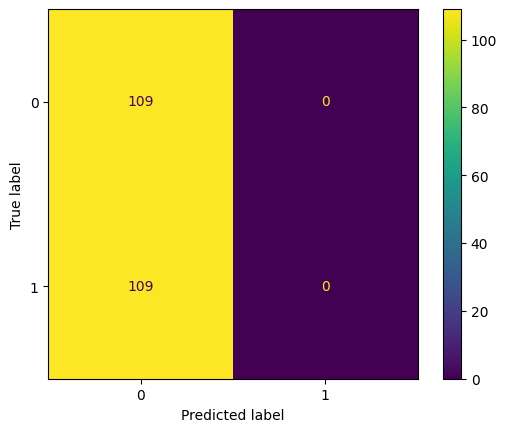

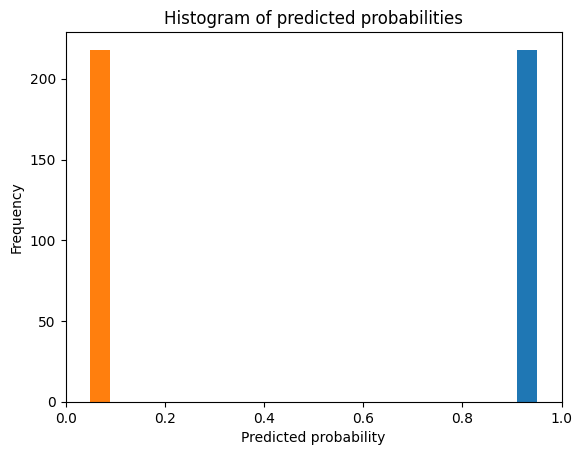

Metrics for Logistic Regression (Before GridSearch):


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  1.0
Test accuracy:  0.9036697247706422
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       109
           1       0.92      0.89      0.90       109

    accuracy                           0.90       218
   macro avg       0.90      0.90      0.90       218
weighted avg       0.90      0.90      0.90       218



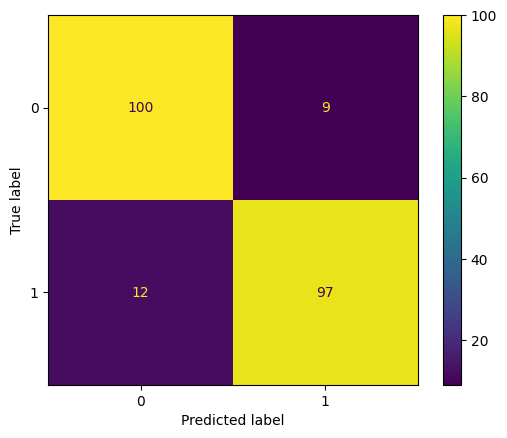

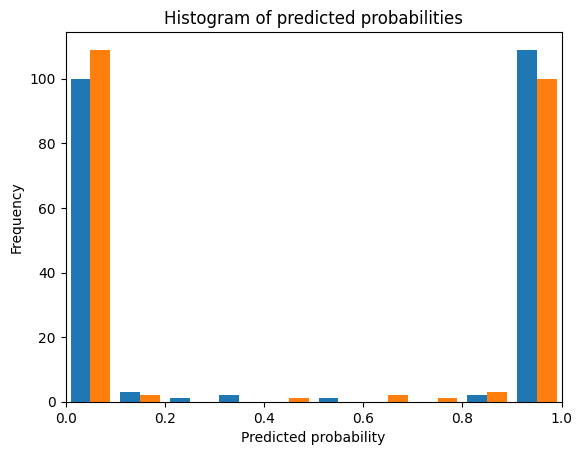

Metrics for Logistic Regression (After GridSearch):


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  1.0
Test accuracy:  0.8944954128440367
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       109
           1       0.91      0.88      0.89       109

    accuracy                           0.89       218
   macro avg       0.89      0.89      0.89       218
weighted avg       0.89      0.89      0.89       218



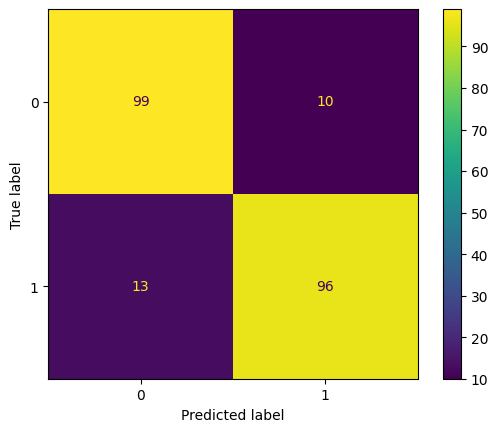

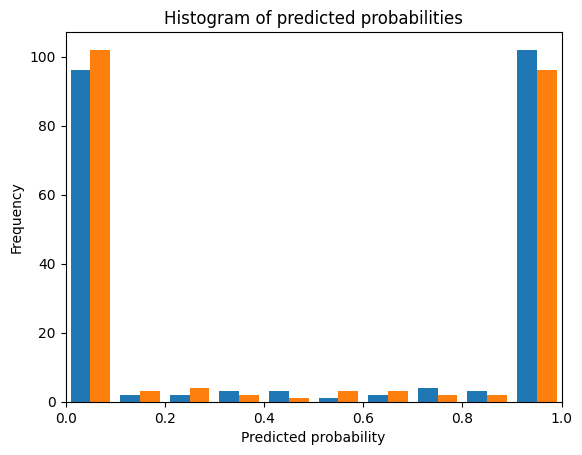

Metrics for KNN (Before GridSearch):
Train accuracy:  0.9019448946515397
Test accuracy:  0.8211009174311926
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.75      0.97      0.84       109
           1       0.96      0.67      0.79       109

    accuracy                           0.82       218
   macro avg       0.85      0.82      0.82       218
weighted avg       0.85      0.82      0.82       218



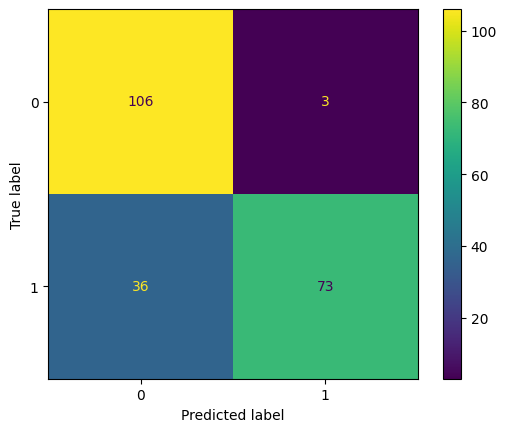

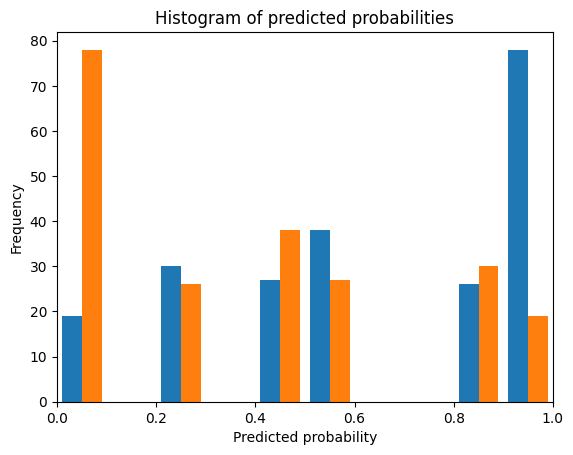

Metrics for KNN (After GridSearch):
Train accuracy:  1.0
Test accuracy:  0.8577981651376146
Classification report (Test): 
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       109
           1       0.95      0.75      0.84       109

    accuracy                           0.86       218
   macro avg       0.87      0.86      0.86       218
weighted avg       0.87      0.86      0.86       218



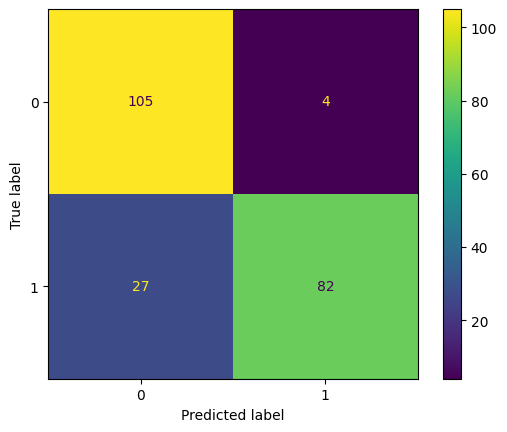

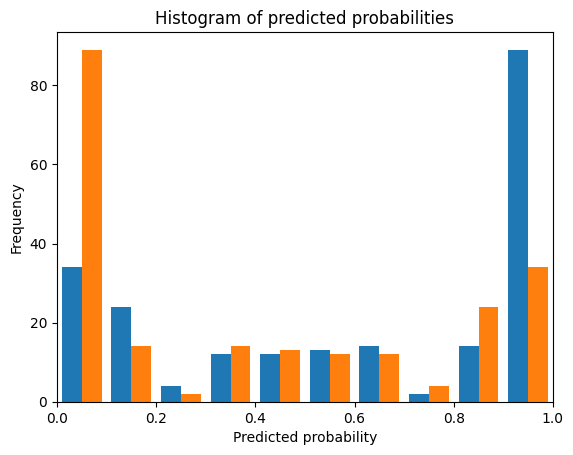

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate a model and print evaluation metrics."""
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Predict values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Print accuracy scores
    print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
    print("Test accuracy: ", accuracy_score(y_test, y_test_pred))

    # Print classification report
    print("Classification report (Test): ")
    print(classification_report(y_test, y_test_pred))

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        # Compute predicted probabilities
        y_test_pred_proba = model.predict_proba(X_test)

        # Create a histogram of the predicted probabilities
        plt.hist(y_test_pred_proba, bins=10)
        plt.xlim(0, 1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability')
        plt.ylabel('Frequency')
        plt.show()

# Print metrics for DummyClassifier
print("Metrics for DummyClassifier:")
evaluate_model(dummy, X_train, X_test, y_train, y_test)

# Print metrics for Logistic Regression BEFORE GridSearch 
print("Metrics for Logistic Regression (Before GridSearch):")
evaluate_model(LogisticRegression(max_iter=1000), X_train, X_test, y_train, y_test)

# Print metrics for Logistic Regression AFTER GridSearch
print("Metrics for Logistic Regression (After GridSearch):")
evaluate_model(grid_search_log_reg.best_estimator_, X_train, X_test, y_train, y_test)

# Print metrics for KNeighborsClassifier BEFORE GridSearch
print("Metrics for KNN (Before GridSearch):")
evaluate_model(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

# Print metrics for KNeighborsClassifier AFTER GridSearch
print("Metrics for KNN (After GridSearch):")
evaluate_model(grid_search_knn.best_estimator_, X_train, X_test, y_train, y_test)


figure out how to use this for evaluation and confusion matrix

# <font color='blue'> CNN </font>

In [14]:
#Add color channels:
def expand_dims(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_images = train_images.map(expand_dims)
test_images = test_images.map(expand_dims)

In [15]:
##Best performance until now

# Load a convolutional base with pre-trained weights
base_model = tf.keras.applications.MobileNet(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,  # Do not include the ImageNet classifier at the top
    pooling='avg')  # Global average pooling applied after the last convolutional block

# Freeze the base model
base_model.trainable = False

# Add a new classifier layers on top
model = tf.keras.Sequential([
    base_model,  # The base model
    tf.keras.layers.Dense(224, activation='relu'),  # Dense layer with 256 units
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),  # Binary classification so only 1 output unit with sigmoid activation
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define number of epochs
num_epochs = 10

# Train the model
history = model.fit(train_images, 
                    epochs=num_epochs,
                    validation_data=test_images)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/10
39/39 [==============================] - 56s 1s/step - loss: 1.8910 - accuracy: 0.5494 - val_loss: 0.6001 - val_accuracy: 0.6514
Epoch 2/10
39/39 [==============================] - 44s 1s/step - loss: 0.8913 - accuracy: 0.4927 - val_loss: 0.5596 - val_accuracy: 0.6284
Epoch 3/10
39/39 [==============================] - 45s 1s/step - loss: 0.7458 - accuracy: 0.5867 - val_loss: 0.5030 - val_accuracy: 0.7156
Epoch 4/10
39/39 [==============================] - 48s 1s/step - loss: 0.6836 - accuracy: 0.6199 - val_loss: 0.4530 - val_accuracy: 0.7752
Epoch 5/10
39/39 [==============================] - 48s 1s/step - loss: 0.6034 - accuracy: 0.6799 - val_loss: 0.4015 - val_accuracy: 0.8532
Epoch 6/10
39/39 [==============================] - 45s 1s/step - loss: 0.5597 - accuracy: 0.7050 - val_loss: 0.3741 - val_accuracy: 0.8899
Epoch 7/10
39/39 [==============================] - 48s 1s/step - loss: 0.4965 - accuracy: 0.75

### CNN Evaluation 

In [16]:
train_loss, train_acc = model.evaluate(train_images, verbose=2)
test_loss, test_acc = model.evaluate(test_images, verbose=2)

print(f'\nTrain accuracy: {train_acc}\nTest accuracy: {test_acc}')

39/39 - 41s - loss: 0.2763 - accuracy: 0.9368 - 41s/epoch - 1s/step
7/7 - 6s - loss: 0.2969 - accuracy: 0.9083 - 6s/epoch - 895ms/step

Train accuracy: 0.936790943145752
Test accuracy: 0.9082568883895874


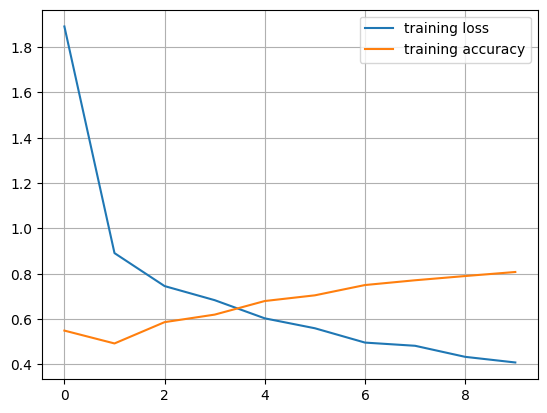

In [17]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

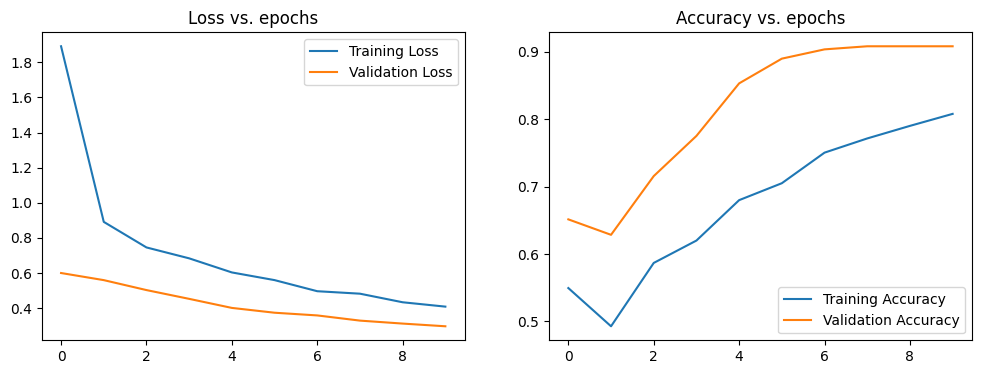

In [18]:
# plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. epochs')

plt.show()

In [19]:
predictions = model.predict(test_images)
results = model.evaluate(test_images)
print(f"Test score: {results}")
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

7/7 [==============================] - 7s 1s/step - loss: 0.2969 - accuracy: 0.9083
Test score: [0.2968994677066803, 0.9082568883895874]
The current model achieved a categorical accuracy of 90.83%!


### CNN Evaluation

In [26]:
def extract_true_labels(filepaths):
    return [os.path.basename(os.path.dirname(fp)) for fp in filepaths]

true_labels = extract_true_labels(filepaths)

label_to_index = {"Open": 1, "Closed": 0}

true_labels = [label_to_index[label] for label in true_labels]

true_labels = np.array(true_labels)

# Convert predictions to labels
predicted_labels = (predictions > 0.5).astype("int32")


In [27]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate a classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 92  17]
 [  3 106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       109
           1       0.86      0.97      0.91       109

    accuracy                           0.91       218
   macro avg       0.92      0.91      0.91       218
weighted avg       0.92      0.91      0.91       218



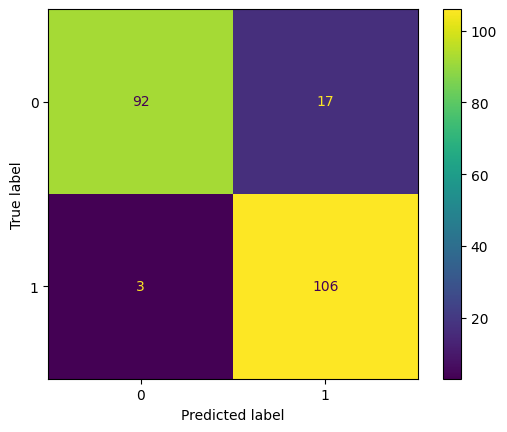

In [28]:
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            )
disp.plot()
plt.show()

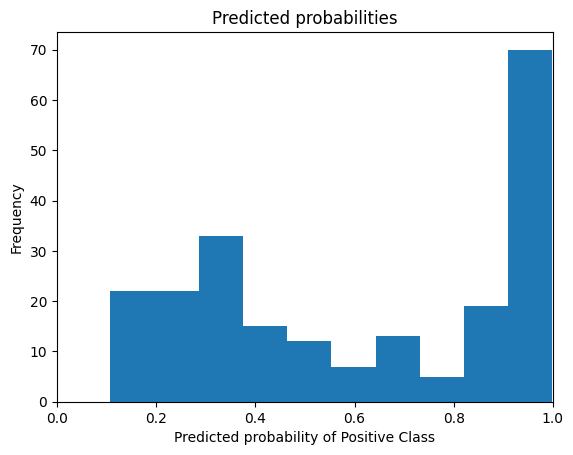

In [29]:
#Plotting a histogram of the predicted probabilities:
plt.hist(predictions, bins=10)
plt.xlim(0, 1)
plt.title('Predicted probabilities')
plt.xlabel('Predicted probability of Positive Class') #Given that the final layer uses sigmoid activation (outputs probabilities of the positive class)
plt.ylabel('Frequency')
plt.show()

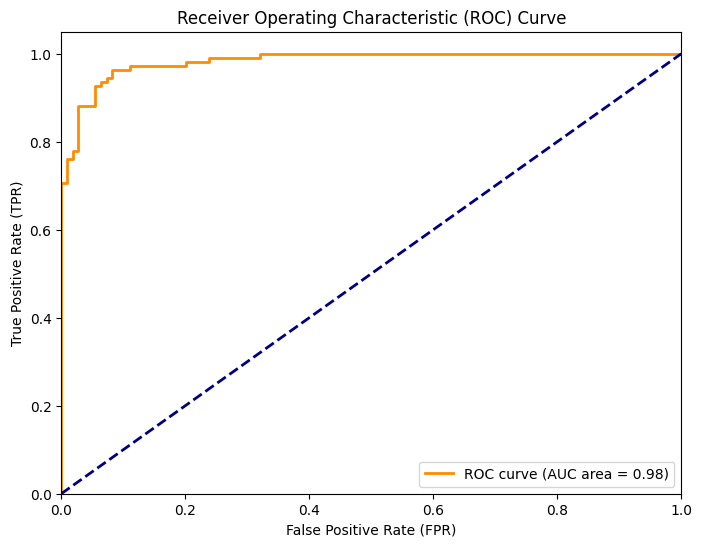

In [30]:
# Calculate the predicted probabilities again
probas = predictions.reshape(-1)

# ROC curve:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, probas)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [40]:
# Number of images you want to display from each class
num_images_to_show = 5

# Containers to store the images and labels
open_images, closed_images = [], []
open_labels, closed_labels = [], []

# Iterate over the test dataset
for images_batch, labels_batch in test_images:
    images_batch = images_batch.numpy()
    labels_batch = labels_batch.numpy()

    # For each image and label in the batch
    for image, label in zip(images_batch, labels_batch):
        # If it's an open case and we still need more open examples
        if label == 1 and len(open_images) < num_images_to_show:
            open_images.append(image)
            open_labels.append(label)
        # If it's a closed case and we still need more closed examples
        elif label == 0 and len(closed_images) < num_images_to_show:
            closed_images.append(image)
            closed_labels.append(label)

    # If we have enough examples from both classes, stop iterating
    if len(open_images) == num_images_to_show and len(closed_images) == num_images_to_show:
        break

# Concatenate the open and closed images and labels
images_to_show = np.concatenate([open_images, closed_images])
labels_to_show = np.concatenate([open_labels, closed_labels])

# Calculate the predictions for the selected images
predictions_to_show = model.predict(images_to_show)
predicted_labels = (predictions_to_show > 0.5).astype("int32").reshape(-1)

# Plot the images with their predicted and true labels
fig = plt.figure(figsize=(10, 2*num_images_to_show))  # adjust the size of the whole figure
for i in range(2*num_images_to_show):
    ax = plt.subplot(2*num_images_to_show, 1, i + 1)  # arrange subplots vertically
    plt.imshow(images_to_show[i].astype("uint8"), cmap='gray')  # assumes your images are grayscale
    plt.title(f"True: {class_names[labels_to_show[i]]}, Predicted: {class_names[predicted_labels[i]]}")
    plt.axis('off')  # hide the x and y axes

# Adjust spacing
fig.tight_layout(pad=2.0)  # increases padding between subplots

plt.show()

InvalidArgumentError: ignored

# <font color='GREEN'>Using Trained Model</font>

In [32]:
directory_own = "/content/drive/MyDrive/prediction_images"


In [33]:
def load_image_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='grayscale',
        batch_size=32,
        image_size=(224, 224),
        shuffle=False,
        seed=42,
        validation_split=False,
        interpolation='mitchellcubic',
        follow_links=False,
        crop_to_aspect_ratio=False,
    )
    return dataset

In [34]:
own_images = load_image_dataset(directory_own)

Found 6 files belonging to 2 classes.


In [35]:
# Let's take one batch of your images
batch_images, batch_labels = next(iter(own_images))

# Grab an image from your own dataset.
i = random.choice(range(batch_images.shape[0]))
img = batch_images[i].numpy()  # Convert the tensor to numpy array

print(img.shape)


(224, 224, 1)


In [36]:
own_images = own_images.map(expand_dims)

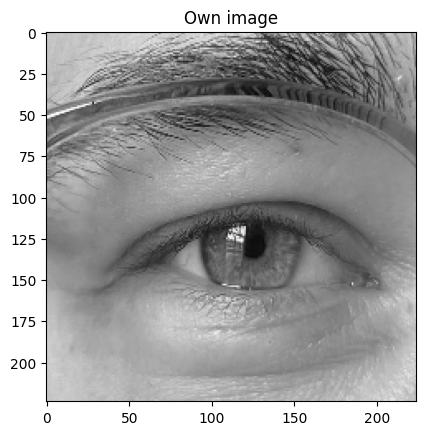

In [37]:
for images, labels in own_images.take(1):
    plt.imshow(images[5].numpy().astype("uint8"), cmap='gray')
    plt.title("Own image")
    plt.show()

In [38]:
predictions = model.predict(own_images)
results = model.evaluate(own_images)
print(f"Test score: {results}")
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

1/1 [==============================] - 0s 308ms/step - loss: 0.4425 - accuracy: 0.8333
Test score: [0.44245728850364685, 0.8333333134651184]
The current model achieved a categorical accuracy of 83.33%!


1/1 [==============================] - 1s 536ms/step


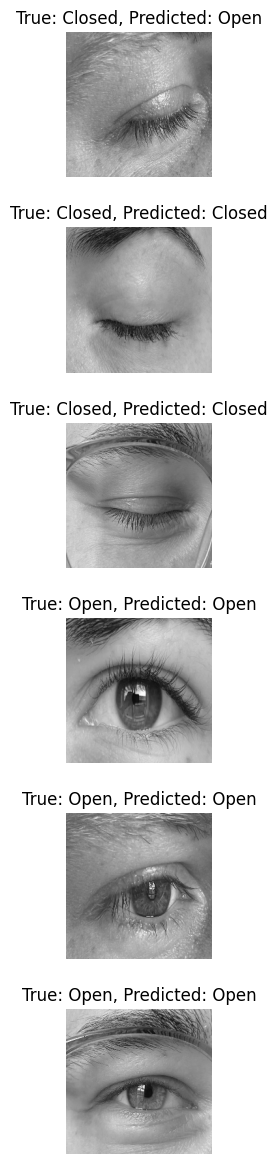

In [39]:
# Containers to store the images and labels
all_images, all_labels = [], []

# Iterate over the own_images dataset
for images_batch, labels_batch in own_images:
    images_batch = images_batch.numpy()
    labels_batch = labels_batch.numpy()

    # For each image and label in the batch
    for image, label in zip(images_batch, labels_batch):
        all_images.append(image)
        all_labels.append(label)

# Convert lists to arrays
images_to_show = np.array(all_images)
labels_to_show = np.array(all_labels)

# Calculate the predictions for the selected images
predictions_to_show = model.predict(images_to_show)
predicted_labels = (predictions_to_show > 0.5).astype("int32").reshape(-1)

# Plot the images with their predicted and true labels
fig = plt.figure(figsize=(10, 2*len(images_to_show)))  # adjust the size of the whole figure
for i in range(len(images_to_show)):
    ax = plt.subplot(len(images_to_show), 1, i + 1)  # arrange subplots vertically
    plt.imshow(images_to_show[i].astype("uint8"), cmap='gray')  # assumes your images are grayscale
    plt.title(f"True: {class_names[labels_to_show[i]]}, Predicted: {class_names[predicted_labels[i]]}")
    plt.axis('off')  # hide the x and y axes

# Adjust spacing
fig.tight_layout(pad=2.0)  # increases padding between subplots

plt.show()
